# Imports

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

from torchvision.models import googlenet, GoogLeNet_Weights, mobilenet_v3_small, MobileNet_V3_Small_Weights, vgg16, VGG16_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) 
torch.cuda.is_available()

cuda


True

# Import data

In [3]:
raw_imgs = []

data_train_c = []
classes_train_c = []
data_train_r = []
classes_train_r = []
bounds_train = []

data_test = []
classes_test = []

img_directories = ["./data/images/butterfly","./data/images/dalmatian", "./data/images/dolphin"]
anno_directories = ["./data/annotations/res_butterfly.txt","./data/annotations/res_dalmatian.txt", "./data/annotations/res_dolphin.txt"]

In [4]:
RESIZE = 350

In [5]:
class_transformer_1 = transforms.Compose([
                           transforms.Resize((RESIZE, RESIZE)),
                           transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                           transforms.RandomRotation(5),
                           transforms.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transforms.ToTensor(),
]),

class_transformer_2 = transforms.Compose([
                                 transforms.Resize((RESIZE, RESIZE)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(10),
                                 transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
                                 transforms.ToTensor(),
                                 transforms.RandomErasing(inplace=True, scale=(0.01, 0.23))]),

transformers = [class_transformer_1, class_transformer_2]

In [6]:
for idx, dirr in enumerate(img_directories):
    data = pd.read_csv(anno_directories[idx], delimiter=',', header=None)
    for idx_2, filename in enumerate(os.listdir(dirr)):
        if(idx_2 < 65):
            classes_train_c.append(idx)
            classes_train_r.append(idx)

            full_path = os.path.join(dirr, filename)
            img = Image.open(full_path)
            
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            img_ = transforms.ToTensor()(img)

            h, w = img_.shape[1:]
            img_ = transforms.Resize(size=(RESIZE,RESIZE))(img_)
            
            x1,y1,x2,y2 = data.iloc[idx_2,1:].values
            x1 = (x1 * RESIZE) / w
            y1 = (y1 * RESIZE) / h
            x2 = (x2 * RESIZE) / w
            y2 = (y2 * RESIZE) / h
            
            bounds_train.append((x1,y1,x2,y2))
            data_train_c.append(img_)
            data_train_r.append(img_)
            
            img_1_c = transformers[0][0](img)
            img_2_c = transformers[1][0](img)
            
            data_train_c.append(img_1_c)
            data_train_c.append(img_2_c)
            classes_train_c.append(idx)
            classes_train_c.append(idx)
        else:
            
            classes_test.append(idx)
            
            full_path = os.path.join(dirr, filename)
            img = Image.open(full_path)
            raw_imgs.append(img)
            img = transforms.ToTensor()(img)
            img = transforms.Resize(size=(RESIZE,RESIZE))(img)
            data_test.append(img)
        
        

d:\anaconda3\envs\DeepL\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
d:\anaconda3\envs\DeepL\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acros

# Custom Dataset

In [7]:
class ImageData(Dataset):
    def __init__(self, X, labels, b_enabled , width, bounds = []):
        super(ImageData, self).__init__()
        self.X = X
        self.labels = labels
        self.b_enabled = b_enabled
        if(self.b_enabled):
            self.bounds = bounds
        
        self.width = width
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx].float()
        label = self.labels[idx]
        label = torch.tensor(label).float()
        if(self.b_enabled):
            x1,y1,x2,y2 = self.bounds[idx]
            x1 = x1 / self.width
            x2 = x2 / self.width
            y1 = y1 / self.width
            y2 = y2 / self.width

            bounds = torch.tensor([x1,y1,x2,y2]).float()
            return X, label, bounds
        return X, label
        
        

In [8]:
train_Dataset_r = ImageData(data_train_r, classes_train_r, True, RESIZE, bounds_train)
train_Dataset_c = ImageData(data_train_c, classes_train_c, False, RESIZE)

In [9]:
BATCH_SIZE = 15

In [10]:
train_loader_r = DataLoader(train_Dataset_r, batch_size=BATCH_SIZE, shuffle=True)
train_loader_c = DataLoader(train_Dataset_c, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_loader_c))
print(len(train_loader_r))

39
13


# Custom model setup

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes = 3, num_bounds = 4):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 5, stride=3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32,64, kernel_size = 5, stride = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
        )
        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512,124),
            nn.ReLU(),
            nn.Linear(124, 64),
            nn.ReLU(),
            nn.Linear(64,num_classes),
            nn.Sigmoid()
        )
        self.regression = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512,124),
            nn.ReLU(),
            nn.Linear(124, 64),
            nn.ReLU(),
            nn.Linear(64,num_bounds),
            nn.Sigmoid()
        )
        
    
    def forward(self, x):
        x_ = self.features(x)
        return (self.classification(x_), self.regression(x_))

In [ ]:
model = MyModel().to(device=device)


# optimizer_c = optim.SGD(model.classification.parameters(), lr=1e-3, momentum=0.9)
# optimizer_r = optim.SGD(model.regression.parameters(), lr=1e-2)

# scheduler_c = lr_scheduler.ReduceLROnPlateau(optimizer_c, mode='min', factor=0.1, patience=3, verbose=True)
# scheduler_r = lr_scheduler.ReduceLROnPlateau(optimizer_r, mode='min', factor=0.1, patience=3, verbose=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn_c = nn.CrossEntropyLoss()
loss_fn_r = nn.MSELoss()

In [ ]:
# def test_model():

## Training

In [ ]:
NUM_EPOCHS = 32

In [ ]:
loss_values_c = []
loss_values_r = []

acc_values_c = []
acc_values_r = []

for epoch in range(NUM_EPOCHS):
    total_loss_c = 0
    total_loss_r = 0
    for X, label, bounds in train_loader_c:
        # optimizer_c.zero_grad()
        # optimizer_r.zero_grad()
        
        X = X.to(device)
        bounds = bounds.to(device)
        
        class_ = torch.zeros(3).to(device)
        class_[int(label.item())] = 1
        
        pred_class, pred_bounds = model(X)
        pred_class = pred_class.view(-1)
        
        loss_c = loss_fn_c(pred_class, class_)
        loss_r = loss_fn_r(pred_bounds, bounds)
        
        loss = loss_c + loss_r  # Adjust weights as needed

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss_c = loss_fn_c(pred_class, class_)
        # loss_c.backward()
        # optimizer_c.step()
        
        # loss_r = loss_fn_r(pred_bounds, bounds)
        # loss_r.backward()
        # optimizer_r.step()
        
        
        total_loss_c += loss_c.item()
        total_loss_r += loss_r.item()
        
    avg_loss_c = total_loss_c / len(train_loader_c)
    loss_values_c.append(avg_loss_c)
    
    # scheduler_c.step(avg_loss_c)
    
    avg_loss_r = total_loss_r / len(train_loader_c)
    loss_values_r.append(avg_loss_r)
    
    # scheduler_r.step(avg_loss_r)
    
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS}')
    print(f'classification loss: {avg_loss_c}')
    print(f'regression loss: {avg_loss_r}')
        
        
        
        

# Pretrained Model

In [11]:
pre_model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
# for param in pre_model.parameters():
#     param.requires_grad=False
# pre_model.classifier[6] = nn.Linear(in_features=pre_model.classifier[6].in_features, out_features=pre_model.classifier[6].out_features)
features = list(pre_model.features)
classifier = list(pre_model.classifier[:-1])
classifier.insert(0, nn.Flatten())
classifier.insert(0, nn.AdaptiveAvgPool2d((7, 7)))
classifier[2] = nn.Linear(in_features=25088, out_features=4096)



In [12]:
classification_head = nn.Sequential(
    *classifier,
    nn.Linear(4096, 3),
    # nn.Softmax()
)

# Bounding box regression head
bbox_head = nn.Sequential(
    *classifier,
    nn.Linear(4096, 4),
    nn.Sigmoid()
)

In [13]:
class CustomVGG16(nn.Module):
    def __init__(self):
        super(CustomVGG16, self).__init__()
        self.features = nn.Sequential(*features)
        self.classifier = classification_head
        self.bbox_regressor = bbox_head
    
    def forward(self, x):
        x = self.features(x)
        class_output = self.classifier(x)
        bbox_output = self.bbox_regressor(x)
        return class_output, bbox_output

In [14]:
comb_model = CustomVGG16().to(device=device)

## Train (Head)

### classification head

In [ ]:
for param in comb_model.parameters():
    param.requires_grad=False
for param in comb_model.classifier.parameters():
    param.requires_grad=True

In [ ]:
optimizer_c = optim.Adam(comb_model.classifier.parameters(), lr=1e-3)
loss_fn_c = nn.CrossEntropyLoss()
scheduler_c = lr_scheduler.ReduceLROnPlateau(optimizer_c, mode='min', factor=0.1, patience=2, verbose=True)

In [ ]:
NUM_EPOCHS = 10

In [ ]:
loss_values_c = []

for epoch in range(NUM_EPOCHS):
    total_loss_c = 0
    for X, label in train_loader_c:
        
        X = X.to(device)
        label = label.long().to(device)
        
        pred_class, pred_bounds = comb_model(X)
        
        loss_c = loss_fn_c(pred_class, label)
        
        optimizer_c.zero_grad()
        loss_c.backward()
        optimizer_c.step()
        
        
        total_loss_c += loss_c.item()
        
    avg_loss_c = total_loss_c / len(train_loader_c)
    loss_values_c.append(avg_loss_c)
    
    scheduler_c.step(avg_loss_c)
    
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS}')
    print(f'classification loss: {avg_loss_c}')
    # print(f'lr: {scheduler_c.get_last_lr()}')
        
        
        
        

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(loss_values_c)
plt.show()

### regression head

In [ ]:
for param in comb_model.parameters():
    param.requires_grad=False
for param in comb_model.bbox_regressor.parameters():
    param.requires_grad=True

In [ ]:
optimizer_r = optim.Adam(comb_model.bbox_regressor.parameters(), lr=1e-3)
loss_fn_r = nn.MSELoss()
scheduler_r = lr_scheduler.ReduceLROnPlateau(optimizer_r, mode='min', factor=0.1, patience=2, verbose=True)

In [ ]:
loss_values_r = []

for epoch in range(NUM_EPOCHS):
    total_loss_r = 0
    for X, label, bounds in train_loader_r:
        
        X = X.to(device)
        bounds = bounds.to(device)
        
        pred_class, pred_bounds = comb_model(X)
        
        loss_r = loss_fn_r(pred_bounds, bounds)

        optimizer_r.zero_grad()
        loss_r.backward()
        optimizer_r.step()
        
        total_loss_r += loss_r.item()
    
    avg_loss_r = total_loss_r / len(train_loader_r)
    loss_values_r.append(avg_loss_r)
    
    scheduler_r.step(avg_loss_r)
    
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS}')
    print(f'regression loss: {avg_loss_r}')
    # print(f'lr: {scheduler_r.get_last_lr()}')
        
        
        
        

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(loss_values_r)
plt.show()

## Train (Finetuning)

In [15]:
for param in comb_model.parameters():
    param.requires_grad = True

In [16]:
optimizer = optim.Adam(comb_model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
loss_fn_c = nn.CrossEntropyLoss()
loss_fn_r = nn.MSELoss()

In [17]:
NUM_EPOCHS = 40

In [18]:
training_loader = [train_loader_c, train_loader_r]

In [19]:
loss_val = []
loss_values_c = []
loss_values_r = []
weight_cls = 1.0
weight_reg = 1.0
for epoch in range(NUM_EPOCHS):
    total_loss_c = 0
    total_loss_r = 0
    total_loss = 0
    for X, label, bounds in train_loader_r:
        # optimizer_c.zero_grad()
        # optimizer_r.zero_grad()
        
        X = X.to(device)
        bounds = bounds.to(device)
        
        label = label.long().to(device)
        
        pred_class, pred_bounds = comb_model(X)
        
        loss_c = loss_fn_c(pred_class, label)
        loss_r = loss_fn_r(pred_bounds, bounds)
        
        loss = weight_cls * loss_c + weight_reg * loss_r  # Adjust weights as needed

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss_c += loss_c.item() * weight_cls
        total_loss_r += loss_r.item() * weight_reg
        total_loss += loss.item()
        
    avg_loss_c = total_loss_c / len(train_loader_r)
    loss_values_c.append(avg_loss_c)
    
    # scheduler_c.step(avg_loss_c)
    
    avg_loss_r = total_loss_r / len(train_loader_r)
    loss_values_r.append(avg_loss_r)
    
    avg_loss = total_loss / len(train_loader_r)
    loss_val.append(avg_loss)
    scheduler.step(avg_loss)
    
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS}')
    # print(f'learning rate: {scheduler.get_last_lr()}')
    print(f'total loss: {avg_loss}')
    print(f'classification loss: {avg_loss_c}')
    print(f'regression loss: {avg_loss_r}')
        

Epoch: 1/40
total loss: 0.9534002404946548
classification loss: 0.8638879748491141
regression loss: 0.08951225597411394
Epoch: 2/40
total loss: 0.32379921754965413
classification loss: 0.30623615361177003
regression loss: 0.017563065513968468
Epoch: 3/40
total loss: 0.04654226301667782
classification loss: 0.031433509597823456
regression loss: 0.015108752709168654
Epoch: 4/40
total loss: 0.16451781228757822
classification loss: 0.1472836243158851
regression loss: 0.017234186856792524
Epoch: 5/40
total loss: 0.04308793801241196
classification loss: 0.03033539736106132
regression loss: 0.012752540588665467
Epoch: 6/40
total loss: 0.014547628780397085
classification loss: 0.0020239291924763867
regression loss: 0.012523699623460952
Epoch: 7/40
total loss: 0.013355825597850176
classification loss: 0.0006880749588862483
regression loss: 0.012667750653166037
Epoch: 8/40
total loss: 0.012316697778610082
classification loss: 0.00031960679091123614
regression loss: 0.011997091082426218
Epoch: 9/

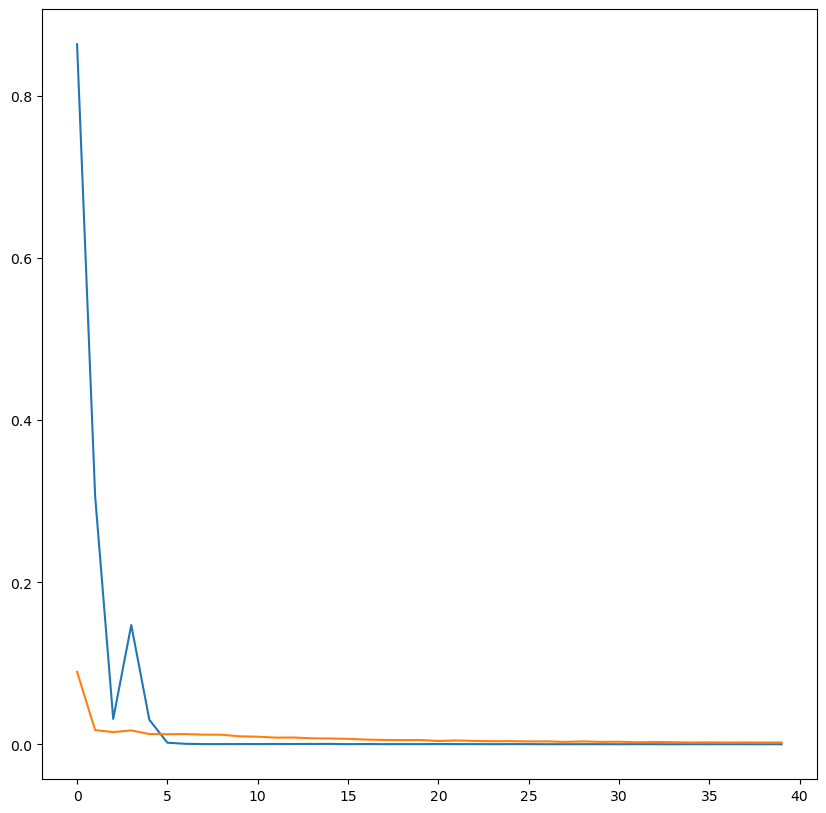

In [20]:
plt.figure(figsize=(10,10))
plt.plot(loss_values_c)
plt.plot(loss_values_r)
plt.show()

# Tests

In [26]:
comb_model.eval()
idx = 8

myImg = Image.open("./data/tests/img_3.jpg")
img = transforms.ToTensor()(myImg)
h, w = img.shape[1:]
img = transforms.Resize(size=(RESIZE,RESIZE))(img)

# x1,y1,x2,y2 = data.iloc[idx_2,1:].values

with torch.no_grad():
    x = img.to(device)
    # x = data_test[idx].to(device)
    x = x.unsqueeze(0)
    # class_ = classes_test[idx]
    pred_class, pred_bounds = comb_model(x)
    x1,y1,x2,y2 = pred_bounds[0][0],pred_bounds[0][1],pred_bounds[0][2],pred_bounds[0][3]
    # w, h = raw_imgs[idx].size
    x1 = x1 * w
    y1 = y1 * h
    x2 = x2 * w
    y2 = y2 * h
    
    draw = ImageDraw.Draw(myImg)
    print(f'x1: {x1}, y1: {y1}')
    print(f'x2: {x2}, y2: {y2}')
    print(torch.argmax(pred_class).item())
    top_left = (x1, y1)
    bottom_right = (x2, y2) 
    
    draw.rectangle([top_left, bottom_right], outline="red", width=3)
    
    myImg.show()
    
    

x1: 112.92843627929688, y1: 47.859291076660156
x2: 468.1951599121094, y2: 177.5253143310547
0


In [ ]:
data, label, bounds = next(iter(train_loader_r))
data = data.to(device)
comb_model.eval()
with torch.no_grad():
    pre_cl, pred_bounds = comb_model(data)
    print(pred_bounds)
    print(bounds)